# Part 2 - Exploratory Data Analysis

In [1]:
# Import required libraries

# For plotting data
import pandas as pd
import matplotlib.pyplot as plt

# For text preprocessing
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
nltk.download("stopwords") 
nltk.download('wordnet') 
stopwords = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer() 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
# Load the dataset
data = pd.read_csv('balanced_data.csv')
data['length'] = data['title'].astype(str).apply(len)
data['words'] = data['title'].apply(lambda x: len(str(x).split()))

## Some basic visualisations

Following the operations in the first notebook, we've balanced the data to a reasonable extent. Here's the visualisation again:

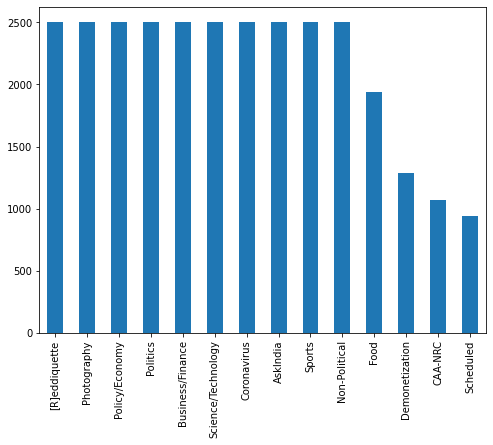

In [3]:
flairs = data['flair'].value_counts()
flairs.plot(kind='bar', figsize=(8,6))

Text(0, 0.5, 'frequency')

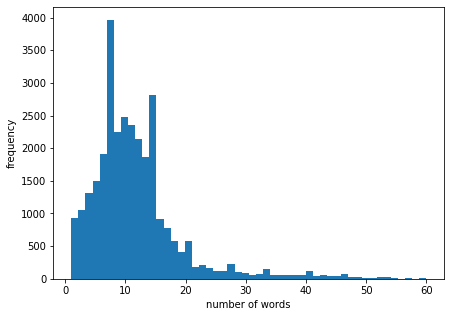

In [4]:
ax = data['words'].plot.hist(bins=50, figsize=(7,5))
ax.set_xlabel("number of words")
ax.set_ylabel("frequency")

Text(0, 0.5, 'frequency')

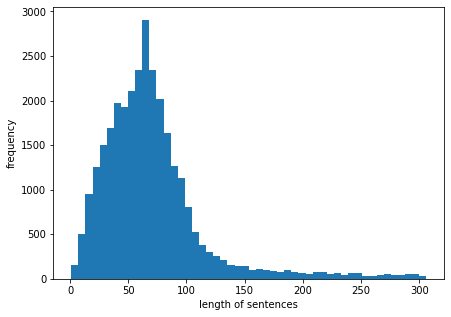

In [5]:
ax = data['length'].plot.hist(bins=50, figsize=(7,5))
ax.set_xlabel("length of sentences")
ax.set_ylabel("frequency")

                         score       
                          mean median
flair                                
AskIndia             46.194800   24.0
Business/Finance     13.573200    1.0
CAA-NRC               1.049533    1.0
Coronavirus           1.748800    1.0
Demonetization       25.834241    1.0
Food                 22.659091    1.0
Non-Political       313.935600  124.0
Photography          70.914800    1.0
Policy/Economy       36.334800   10.0
Politics            220.393600  125.0
Scheduled             4.757188    1.0
Science/Technology   28.528000    2.0
Sports               24.066800    1.0
[R]eddiquette        51.133600   13.0


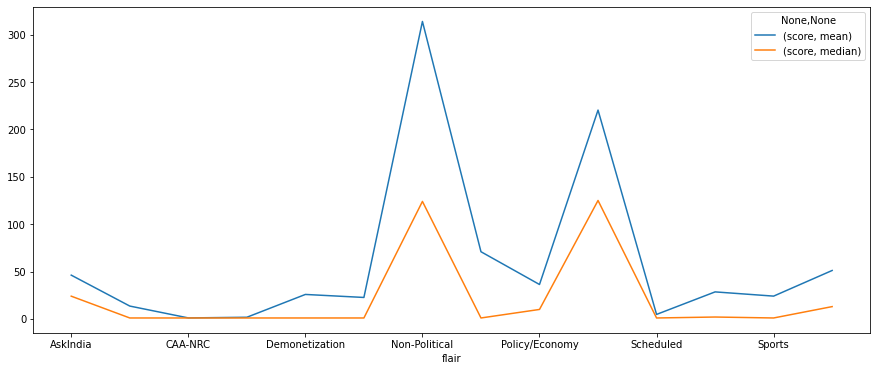

In [6]:
# Let's plot the pivot table

pivot = data.pivot_table(index=['flair'], values=['score'], aggfunc={'median','mean'})
print(pivot)
pivot.plot(figsize=(15,6))
plt.show()

As we can see, the posts tagged Political and Non-political gain the most traction on this Subreddit. This indicates that the less popular flairs as subject to lesser scrutiny from the Subreddit moderators as to the appropriateness of the flair attached to the post. For example, let's look at a few entries from the dataset.

In [7]:
print(data['title'][2012], data['flair'][2012], data['score'][2012], sep='\n')

50 Lakh Men Lost Their Jobs After Demonetisation: Report
Policy/Economy
204


This post should've more appropriately been tagged under 'Demonetization'.
Furthermore, there are a lot of posts that simply don't provide a lot of information for appropriate preidictions.

In [8]:
print(data['flair'][2504], data['title'][2504], sep=' || ')
print(data['flair'][2540], data['title'][2540], sep=' || ')
print(data['flair'][2571], data['title'][2571], sep=' || ')

Non-Political || #redisgood
Food || This is ultimate!
[R]eddiquette || R/mangalore - GRMD 2019


The only remedy would be to re-label the data by hand more appropriately, or eliminate these entries during data acquisition (which wouldn't be possible without manual intervention). Given that that's not feasible for the current task, we'll go forth even with this faulty data and see the kind of results we get.

## Data preprocessing

In [0]:
# Standard NLP data cleaning techniques

# Function for standard cleaning of text (remove punctuations, abbreviations, etc.) using regular expressions
def standard_clean(text):
  text = str(text)
  text = text.lower()
  text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
  text = re.sub(r"what's", "what is ", text)
  text = re.sub(r"\'s", " ", text)
  text = re.sub(r"\'ve", " have ", text)
  text = re.sub(r"can't", "cannot ", text)
  text = re.sub(r"n't", " not ", text)
  text = re.sub(r"i'm", "i am ", text)
  text = re.sub(r"\'re", " are ", text)
  text = re.sub(r"\'d", " would ", text)
  text = re.sub(r"\'ll", " will ", text)
  text = re.sub(r",", " ", text)
  text = re.sub(r"\.", " ", text)
  text = re.sub(r"!", " ! ", text)
  text = re.sub(r"\/", " ", text)
  text = re.sub(r"\^", " ^ ", text)
  text = re.sub(r"\+", " + ", text)
  text = re.sub(r"\-", " - ", text)
  text = re.sub(r"\=", " = ", text)
  text = re.sub(r"'", " ", text)
  text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
  text = re.sub(r":", " : ", text)
  text = re.sub(r" e g ", " eg ", text)
  text = re.sub(r" b g ", " bg ", text)
  text = re.sub(r" u s ", " american ", text)
  text = re.sub(r"\0s", "0", text)
  text = re.sub(r" 9 11 ", "911", text)
  text = re.sub(r"e - mail", "email", text)
  text = re.sub(r"j k", "jk", text)
  text = re.sub(r"\s{2,}", " ", text)
  return text

# Function to remove stopwords from a sentence
def remove_stopwords(text):
  text = text.split()
  clean = ""
  for w in text:
    if w not in stopwords:
      clean = clean + " " + w
  return str(clean[1:])

# Function to lemmatize words of a sentence using Lemmatizer object
def lemmatize(text):
  text = text.split()
  clean = ""
  for w in text:
    clean = clean + " " + lemmatizer.lemmatize(w)
  return str(clean[1:])

# Wrapper function to clean the text
def clean(text):
  text = standard_clean(text)
  text = remove_stopwords(text)
  text = lemmatize(text)
  return text

In [0]:
data['title_clean'] = data.title.map(lambda x: clean(x))

# Save the preprocessed data
data.to_csv('preprocessed_data.csv', index=False)

In [0]:
# Assigning keys to all of the flairs

data = data[['flair', 'title_clean']]
data = data[pd.notnull(data['title_clean'])]
data['flair_id'] = data['flair'].factorize()[0]
flair_id_df = data[['flair', 'flair_id']].drop_duplicates().sort_values('flair_id')
flair_to_id = dict(flair_id_df.values)
id_to_flair = dict(flair_id_df[['flair_id', 'flair']].values)

In [0]:
# Create a feature space using tf-idf vectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=20, ngram_range=(1, 2))
features = tfidf.fit_transform(data.title_clean).toarray()
labels = data.flair_id

In [13]:
# Find out the most correlated ngrams for each flair

ngrams = []
for flair, id in sorted(flair_to_id.items()):
    idx = np.argsort(chi2(features, labels==id)[0])
    feature_names = np.array(tfidf.get_feature_names())[idx]
    unigrams = []
    bigrams = []
    for fn in feature_names:
        n = len(fn.split(' '))
        if n==1:
            unigrams.append(fn)
        if n==2:
            bigrams.append(fn)
    ngrams.append([flair, ', '.join(unigrams[-5:]), ', '.join(bigrams[-5:])])
ngrams = pd.DataFrame(ngrams, columns=['flair', 'correlated unigrams', 'correlated bigrams'])
pd.set_option('display.max_colwidth', -1)
ngrams

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  app.launch_new_instance()


,flair,correlated unigrams,correlated bigrams
0,AskIndia,"experience, anyone, askindia, advice, help","people india, career advice, please help, need advice, need help"
1,Business/Finance,"business, service, specialist, manufacturer, grotal","vashikaran specialist, plant manufacturer, manufacturer india, top 20, grotal com"
2,CAA-NRC,"bagh, shaheen, protest, nrc, caa","delhi riot, caa protest, caa nrc, shaheen bagh, anti caa"
3,Coronavirus,"19, corona, lockdown, covid, coronavirus","coronavirus lockdown, corona virus, 21 day, social distancing, covid 19"
4,Demonetization,"500, cash, rupee, note, bank","black money, pmc bank, bank account, yes bank, central bank"
5,Food,"biryani, curry, chicken, food, recipe","covid 19, food delivery, south indian, indian food, street food"
6,Non-Political,"driver, traffic, cyclone, man, np","discussion thread, 20 year, ia officer, covid 19, year old"
7,Photography,"lake, beautiful, shot, sunset, oc","redmi note, taj mahal, one plus, poco f1, himachal pradesh"
8,Policy/Economy,"slowdown, gdp, economic, report, economy","lakh crore, economic slowdown, nirmala sitharaman, comment invited, indian economy"
9,Politics,"cartoon, gandhi, congress, bjp, modi","amit shah, satish acharya, pm modi, narendra modi, rahul gandhi"
